In [1172]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1173]:
from nca.utils import conv_same

In [1174]:
def make_gif(nca_out, fps=10, size=(500, 500)):
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize(size, Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [2055]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 3
        hid = 5

        self.kernel = nn.Sequential(
            conv_same(1, perc, ks=7, padding_mode="zeros"),
        )
        self.hid = nn.Sequential(
            conv_same(perc, hid, ks=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(hid),
            conv_same(hid, hid, ks=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(hid),
        )
        self.rule = conv_same(hid, 1, ks=1, bias=False)
        self.lerp = conv_same(hid, 1, ks=1, bias=False)

        for p in self.kernel.parameters():
            nn.init.normal_(p, 1, 0)
        for p in list(self.rule.parameters()) + list(self.hid.parameters()) + list(self.lerp.parameters()):
            nn.init.uniform_(p, -1.2, 1.2)

    def forward(self, x, steps):
        seq = [x]
        for i in range(steps):
            perc = self.kernel(x)
            hid = self.hid(perc)
            y = torch.tanh(self.rule(hid))
            l = torch.sigmoid(self.lerp(hid))
            x = l * x + (1 - l) * y
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [2118]:
nca = SimpleNCA()

In [2119]:
inp = torch.randn(3, 1, 128, 128)

In [2120]:
out = nca(inp, steps=50)
out.shape

torch.Size([3, 51, 1, 128, 128])


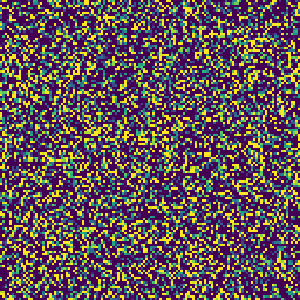

In [2121]:
make_gif(out[1,:,0], size=(300, 300))

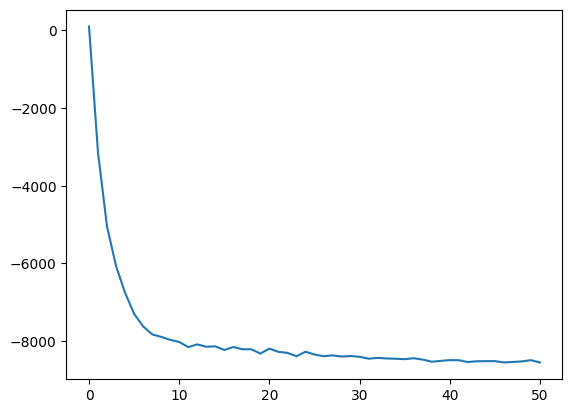

In [2122]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
plt.plot(vals)

In [2123]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [2124]:
ds = MNIST(root="./.data", download=True, transform=ToTensor())

In [2125]:
bs = 64
num_classes = 3
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

In [2126]:
batch = next(iter(dl))

In [2127]:
def sample_random_input(dl):
    it = iter(dl)
    while True:
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(dl)
        bs, _, H, W = x.shape
        screen_W, screen_H = 64, 32
        screen = torch.zeros(bs, 1, screen_H, screen_W)
        top, left = 2, 2
        screen[:, :, top:top+H, left:left+W] = x
        yield screen, y

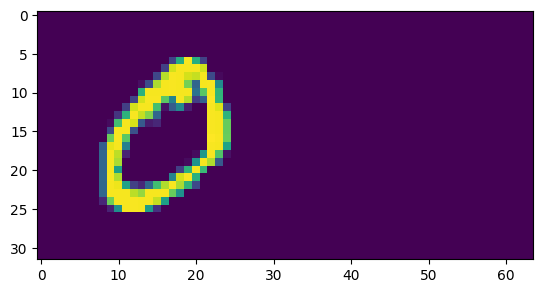

In [2128]:
gen = sample_random_input(dl)
batch = next(gen)
im = batch[0][0,0]
plt.imshow(im)

In [2129]:
out = nca(batch[0], steps=40)

In [2130]:
out[:,:,0,3:31:12,35:50] = 1


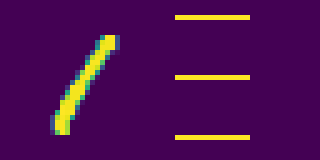

In [2131]:
make_gif(out[1,:,0], size=(64 * 5, 32 * 5))

In [2132]:
def optim_step(nca, batch, optim, device):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    out = nca(x, steps=40)
    sums = out.reshape(*out.shape[:2], -1).mean(axis=2)
    clf_out = out[:,:,0,3:31:12,45:50].mean(axis=[1, -1])
    loss = F.cross_entropy(clf_out, y) \
         + F.mse_loss(sums[:,0], sums[:,-1]) \
         + F.mse_loss(sums[:,0], sums[:,1]) \
         + F.mse_loss(sums[:,0], sums[:,8])
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss

In [2133]:
from copy import deepcopy

In [2134]:
sums = out.reshape(*out.shape[:2], -1).mean(axis=2)

In [2135]:
lr = 0.0001
target_nca = deepcopy(nca)
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [2136]:
device = "cuda"
target_nca = target_nca.to(device)

In [2141]:
history = []
pbar = tqdm(range(5000))
for i in pbar:
    batch = next(gen)
    loss = optim_step(target_nca, batch, optim, device)
    pbar.set_description(f"Loss: {loss:.10f}")
    history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

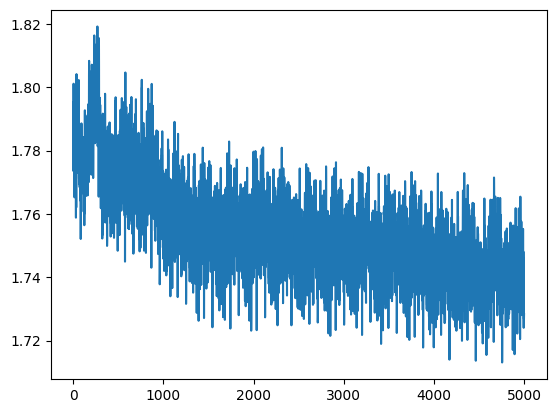

In [2138]:
plt.plot(history)

In [2139]:
x, y = batch
x = x.to(device)
y = y.to(device)
out = target_nca(x, steps=40)


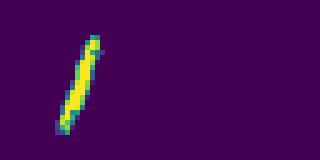


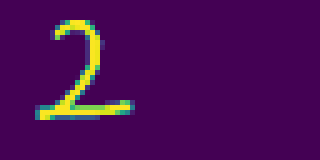


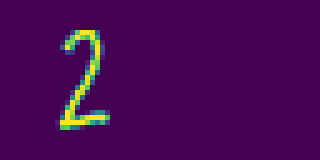


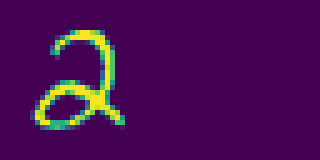


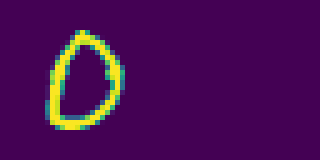

In [2140]:
display(make_gif(out[0,:,0], size=(64 * 5, 32 * 5)))
display(make_gif(out[1,:,0], size=(64 * 5, 32 * 5)))
display(make_gif(out[2,:,0], size=(64 * 5, 32 * 5)))
display(make_gif(out[3,:,0], size=(64 * 5, 32 * 5)))
display(make_gif(out[4,:,0], size=(64 * 5, 32 * 5)))